# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [140]:
# Load the libraries as required.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pickle
import shap
from glob import glob

In [122]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [123]:
#Features dataframe
X = fires_dt.drop(columns=['area'])

#Target data
y = fires_dt['area']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [124]:
# convert numeric features to standard scale
numeric_features = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
numeric_transformer = StandardScaler()

# Convert categorical features to one-hot encoding
categorical_features = ['month', 'day']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [125]:
# convert numeric features to standard scale
numeric_features2 = ['dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
numeric_transformer2 = MinMaxScaler()

# Convert numeric features with quantiles
non_linear_features2 = ['temp', 'ffmc', 'wind']
non_linear_transformer2 = QuantileTransformer(n_quantiles=300,output_distribution='normal')

# Convert categorical features to one-hot encoding
categorical_features2 = ['month', 'day']
categorical_transformer2 = OneHotEncoder(handle_unknown='ignore')

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [126]:
# Pipeline A = preproc1 + baseline  thorugh lasso
Pipeline_A = ColumnTransformer(transformers=[
    ('numerical', numeric_transformer,numeric_features),
    ('categorical',categorical_transformer, categorical_features)],remainder='passthrough')
    
Pipe_A = Pipeline(steps=[('preproc1', Pipeline_A),
                         ('lasso_reg', Lasso(alpha=1, random_state=42))])

Pipe_A

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('lasso_reg', Lasso(alpha=1, random_state=42))])

In [127]:
# Pipeline B = preproc2 + baseline though decision tree
Pipeline_B = ColumnTransformer(transformers=[
    ('numerical2', numeric_transformer2,numeric_features2),
    ('categorical2',categorical_transformer2,categorical_features2),
    ('non_linear2',non_linear_transformer2,non_linear_features2)],remainder='passthrough')
    
Pipe_B = Pipeline(steps=[('preproc2', Pipeline_B),
                         ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2))])

Pipe_B

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical2', MinMaxScaler(),
                                                  ['dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('non_linear2',
                                                  QuantileTransformer(n_quantiles=300,
                                                                      output_distribution='normal'),
                                                  ['temp', 'ffmc', 'wind'])])),
                ('svr', SVR(epsilon=0.2))])

In [128]:
# Pipeline C = preproc1 + advanced model KNN Regressor
Pipeline_C = ColumnTransformer(transformers=[
    ('numerical', numeric_transformer,numeric_features),
    ('categorical',categorical_transformer, categorical_features)],remainder='passthrough')
    
Pipe_C = Pipeline(steps=[('preproc1', Pipeline_C),
                         ('knn_regressor', KNeighborsRegressor(n_neighbors=5))])

Pipe_C

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('knn_regressor', KNeighborsRegressor())])

In [129]:
# Pipeline D = preproc2 + advanced model though Random Forest Regressor

Pipeline_D = ColumnTransformer(transformers=[
    ('numerical2', numeric_transformer2,numeric_features2),
    ('categorical2',categorical_transformer2,categorical_features2),
    ('non_linear2',non_linear_transformer2,non_linear_features2)],remainder='passthrough')
    
Pipe_D = Pipeline(steps=[('preproc2', Pipeline_D),
                         ('random_forest_reg', RandomForestRegressor(random_state=42))])

Pipe_D

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical2', MinMaxScaler(),
                                                  ['dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('non_linear2',
                                                  QuantileTransformer(n_quantiles=300,
                                                                      output_distribution='normal'),
                                                  ['temp', 'ffmc', 'wind'])])),
                ('random_forest_reg', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [130]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [131]:
#Pipe A grid search and parameter tunning
param_grid_A = {
    'lasso_reg__alpha': [0.1, 0.3, 1.0, 3.0]
}


grid_A = GridSearchCV(Pipe_A, param_grid=param_grid_A, cv=5, scoring='neg_mean_squared_error')
grid_A.fit(X_train,Y_train)

print(grid_A.best_params_)
print(grid_A.best_score_)

{'lasso_reg__alpha': 3.0}
-2075.4780000591963


In [132]:
#Pipe B grid search and parameter tunning
param_grid_B = {
    'svr__C': [0.1, 1.0, 10.0]
}


grid_B = GridSearchCV(Pipe_B, param_grid=param_grid_B, cv=5, scoring='neg_mean_squared_error')
grid_B.fit(X_train,Y_train)

print(grid_B.best_params_)
print(grid_B.best_score_)

{'svr__C': 10.0}
-2191.9493363217534


In [133]:
#Pipe C grid search and parameter tunning
param_grid_C = {
    'knn_regressor__n_neighbors': [3, 5, 7, 9]
}

grid_C = GridSearchCV(Pipe_C, param_grid=param_grid_C, cv=5, scoring='r2')
grid_C .fit(X_train,Y_train)

print(grid_C.best_params_)
print(grid_C.best_score_)


{'knn_regressor__n_neighbors': 7}
-0.45233038207449017


In [142]:
#Pipe D grid search and parameter tunning
param_grid_D = {
    'random_forest_reg__min_samples_leaf': [1, 3, 5, 10]
}

grid_D = GridSearchCV(Pipe_D, param_grid=param_grid_D, cv=5, scoring='r2')
grid_D.fit(X_train,Y_train)

print(grid_D.best_params_)
print(grid_D.best_score_)

{'random_forest_reg__min_samples_leaf': 10}
-0.2686069183924384


# Evaluate

+ Which model has the best performance?

I guess Pipe D would be the best as the error is the lowest between all of the models. Pipe C would be anothe model i could be thionking about. 

Definately not A nor B.

# Export

+ Save the best performing model to a pickle file.

In [ ]:
with open('grid_D.pkl', 'wb') as best:
    pickle.dump(grid_D, best)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [148]:
best_model = grid_D.best_estimator_


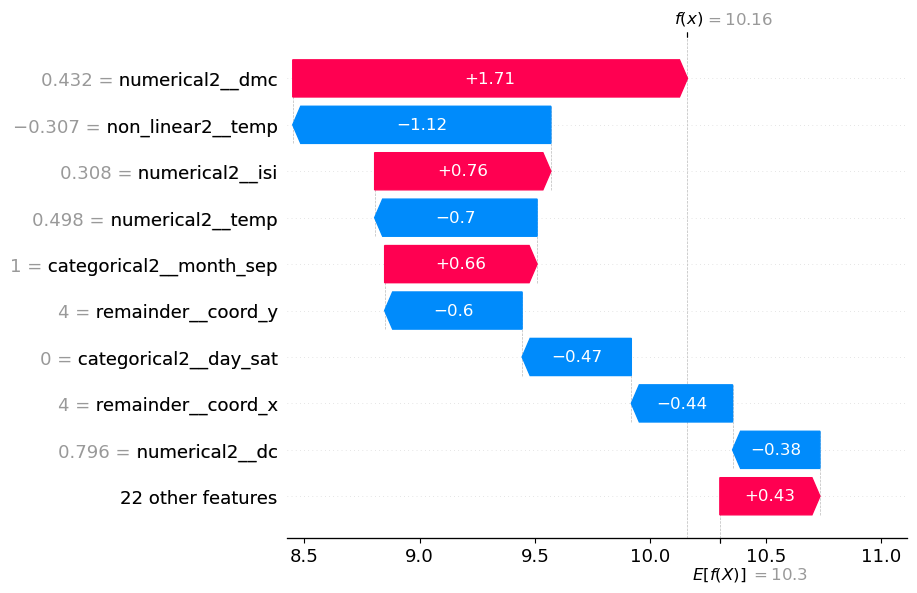

In [ ]:
data_transform  = best_model.named_steps['preproc2'].transform(X_train)

explainer = shap.Explainer(best_model.named_steps['random_forest_reg'], data_transform,feature_names = best_model.named_steps['preproc2'].get_feature_names_out())
shap_values = explainer(data_transform)
shap.plots.waterfall(shap_values[1])


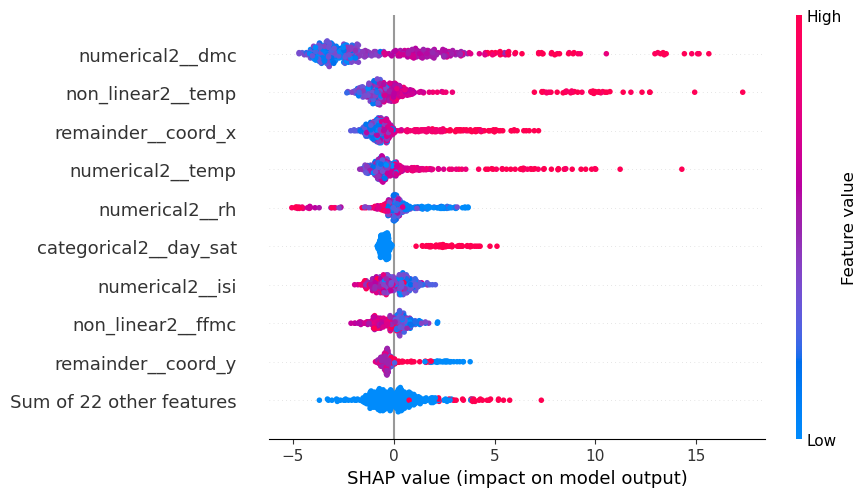

In [155]:
shap.plots.beeswarm(shap_values)

Most important: DMC, TEMP, ISI, cood_y, coord_x, day_sat,...
Least relevant:  Rain, month_apr/jan/dec/jun/may/oct/nov,...

In [162]:
feature_names = best_model.named_steps['preproc2'].get_feature_names_out()
shap_importance = np.abs(shap_values.values).mean(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_importance
}).sort_values(by='mean_abs_shap', ascending=True)
importance_df

,feature,mean_abs_shap
6,numerical2__rain,0.000000
7,categorical2__month_apr,0.000000
11,categorical2__month_jan,0.000000
9,categorical2__month_dec,0.000000
13,categorical2__month_jun,0.000000
15,categorical2__month_may,0.000000
17,categorical2__month_oct,0.000000
16,categorical2__month_nov,0.000000
23,categorical2__day_thu,0.001660
10,categorical2__month_feb,0.018931


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.